### Hopfield Network model of associative memory

#### Members
* First name: Kaleem
* Last name: Corbin
* Sciper: 295433


* First name: Victor
* Last name: Wiklund
* Sciper: 300706

date: 29.04.2019


** Remember **

If you are asked for plots: The appearance of the plots (labelled axes, ** useful scaling **, etc.) is important!

If you are asked for discussions: Answer in a precise way and try to be concise. 


** Submission **

Rename this notebook to Ex2_FirstName_LastName_Sciper.ipynb and upload that single file on moodle before the deadline.

Exercise instructions are given in this notebook file.

** Rules: **

1) You are strongly encouraged to work in groups of 2. You are allowed to work alone. Groups of 3 or more are NOT allowed

2) If you work in a group of 2, BOTH people should upload the same notebook file  

3) If you work alone, you can't share your notebook file with anyone else

4) Discussion between groups is encouraged, but you can't share your code or text

5) The points assigned to each exercise are indicated in the notebook file

6) You should upload a jupyter notebook file with all code run and picture visible. We are not going to run your notebook.

7) Read carefully the instructions at the beginning of the notebook file, answer in a clear and concise way to open questions

8) You have to understand every line of code you write in this notebook. We will ask you questions about your submission during a fraud detection session during the last week of the semester

## \* \* \* \* Programming Notes : Copying and slicing lists and numpy arrays \* \* \* \*
We would like to take the opportunity to bring to your attention certain features of Python, that might lead to unwanted behaviour and serious mistakes, if one is not aware of them. 
Please check the Python Cheat Sheet file on the moodle (https://moodle.epfl.ch/mod/page/view.php?id=981134 Part 4 of the ipynb file) for some examples of the following notes:

* Assigning a list to a new variable does not create a copy of the list, but creates a variable that points to the list. This means that modifying the second variable, also modifies the original list.
* Assigning a slice of a list to a new variable, creates a copy of the list. Any modification to the sliced list does not modify the original.

Now when it comes to numpy arrays:
* Assigning a numpy array to a new variable does not create a copy of the array, but creates a variable that points to the array. This means that modifying the second variable, also modifies the original array. (same as above)
* Assigning a slice of a numpy array to a new variable creates a variable that points to the corresponding elements of the original array as well! (contrary to what we saw above!) This means that modifying the second variable, also modifies the original array!
* To copy the original array and ensure that it is not modified by any modification of its copied version, the method copy() should be used.

## 8.1. Getting started:

See [Chapter 17](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html) Section 2 for an introduction to Hopfield networks.

We provide a couple of functions to easily create patterns, store them in the network and visualize the network dynamics. Check the modules [`hopfield_network.network`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#module-neurodynex.hopfield_network.network), [`hopfield_network.pattern_tools`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#module-neurodynex.hopfield_network.pattern_tools) and [`hopfield_network.plot_tools`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#module-neurodynex.hopfield_network.plot_tools) to learn the building blocks we provide.

***Note:*** If you instantiate a new object of class `network.HopfieldNetwork` it’s default dynamics are deterministic and synchronous. That is, all states are updated at the same time using the sign function. We use this dynamics in all exercises described below.

Run the following code. Read the inline comments and check the documentation. The patterns and the flipped pixels are randomly chosen. Therefore the result changes every time you execute this code. Run it several times and change some parameters like nr_patterns and nr_of_flips.

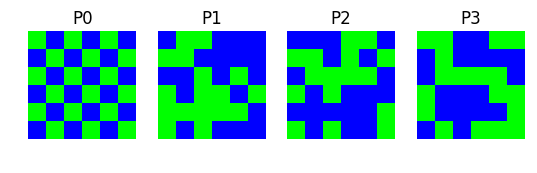

/home/sigis/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


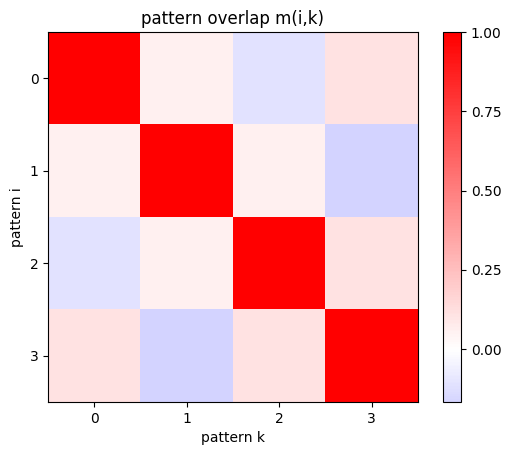

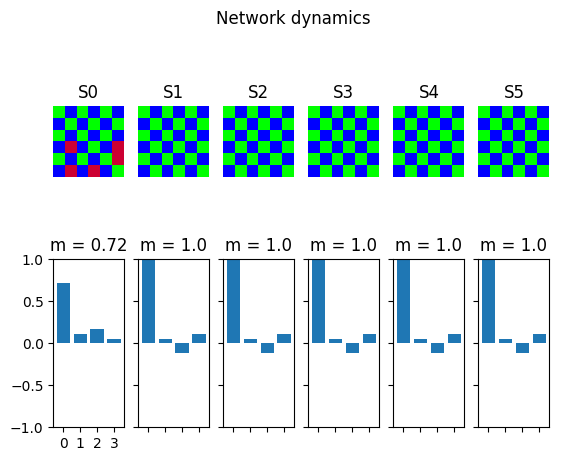

In [1]:
%matplotlib inline
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
from matplotlib import rcParams, pyplot as plt
plt.style.use('default')

import numpy as np
np.random.seed(26)
from __future__ import division
#rcParams['figure.figsize'] = 10,10
pattern_size = 6

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)

# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=3, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)


# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=5)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=5)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)

# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

***Note:*** The network state is a vector of N neurons. For visualization we use 2d patterns which are two dimensional numpy.ndarrays of size = (length, width). To store such patterns, initialize the network with N = length x width neurons.

## 8.2. Introduction: Hopfield-networks

This exercise uses a model in which neurons are pixels and take the values of -1 (off) or +1 (on). The network can store a certain number of pixel patterns, which is to be investigated in this exercise. During a retrieval phase, the network is started with some initial configuration and the network dynamics evolves towards the stored pattern (attractor) which is closest to the initial configuration.

The dynamics is that of equation:
\begin{equation}
    S_i(t+1) = sgn\left(\sum_j w_{ij} S_j(t)\right)
\end{equation}
In the Hopfield model each neuron is connected to every other neuron (full connectivity). The connection matrix is
\begin{equation}
    w_{ij} = \frac{1}{N}\sum_{\mu} p_i^\mu p_j^\mu
\end{equation}
where N is the number of neurons, $p^{\mu}_i$
 is the value of neuron $i$
 in pattern number $\mu$
 and the sum runs over all patterns from $\mu=1$
 to $\mu=P$. This is a simple correlation based learning rule (Hebbian learning). Since it is not a iterative rule it is sometimes called one-shot learning. The learning rule works best if the patterns that are to be stored are random patterns with equal probability for on (+1) and off (-1). In a large networks (N to infinity) the number of random patterns that can be stored is approximately 0.14 times N.



## 8.3. Exercise: N=6x6 Hopfield-network

We study how a network stores and retrieve patterns. Using a small network of only 36 neurons allows us to have a close look at the network weights and dynamics.

### 8.3.1. Question: Storing a single pattern
#### [2 + 2 + 3 points]

Modify the Python code given above to implement this exercise:

Create a network with N=36 neurons.
Create a single 6 by 6 checkerboard pattern.
Store the checkerboard in the network.
Set the initial state of the network to a noisy version of the checkerboard (nr_flipped_pixels = 5).
Let the network dynamics evolve for 5 iterations.
Plot the sequence of network states along with the overlap of network state with the checkerboard.
Now test whether the network can still retrieve the pattern if we increase the number of flipped pixels. 

In [2]:
# Convenience function to play around with the effect of adjusting amount of bits flipped in initial pattern
def plot_with_flip(flips):
    noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=flips)
    hopfield_net.set_state_from_pattern(noisy_init_state)
    states = hopfield_net.run_with_monitoring(nr_steps=5)
    states_as_patterns = factory.reshape_patterns(states)
    plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics with " + str(flips) +" flips")
    return states_as_patterns

#Plot the overlap with the original pattern as a function of the number of bits flipped
def plot_with_overlap():
    overlap_flipped = []
    checkerboard = factory.create_checkerboard()
    pattern_list = [checkerboard]

    for i in range(pattern_size**2):
        #Create checkerboard
        hopfield_net.store_patterns(pattern_list)

        # create a noisy version of a pattern and use that to initialize the network
        noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=i)
        hopfield_net.set_state_from_pattern(noisy_init_state)
        states = hopfield_net.run_with_monitoring(nr_steps=5)

        # each network state is a vector. reshape it to the same shape used to create the patterns.
        states_as_patterns = factory.reshape_patterns(states)
        #Detect overlap between checkerboard and final sequence (retrieve the last sequence (last index)
        overlap_flipped.append(pattern_tools.compute_overlap_list(checkerboard, states_as_patterns)[-1])
        #print('number of flips: {}, overlap with final sequence: {}'.format(i,overlap_p))

    plt.figure( figsize = [12, 4] ) 
    plt.plot(overlap_flipped, marker='o')
    plt.xticks(np.arange(pattern_size**2))
    plt.yticks([-1,0,1])
    plt.xlabel("Number of flips")
    plt.ylabel("Overlap")
    plt.title("Overlap to original pattern as a function of the number of flips")
    

In [3]:
np.random.seed(26)
pattern_size = 6

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)

# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()

#Two checkerboards since the indices on the plotted image gets weird otherwise
pattern_list = [checkerboard]

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

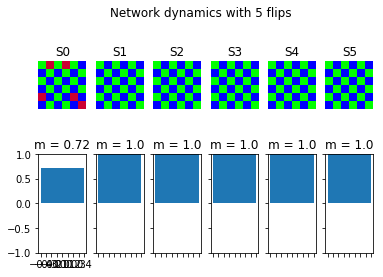

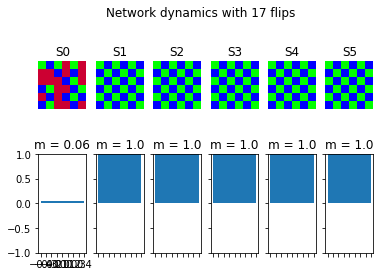

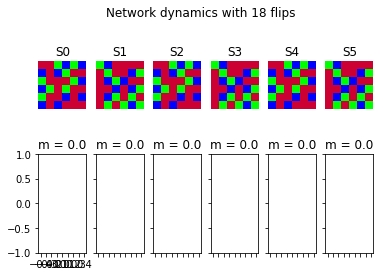

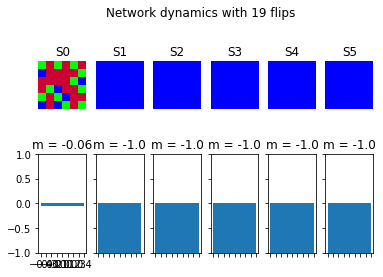

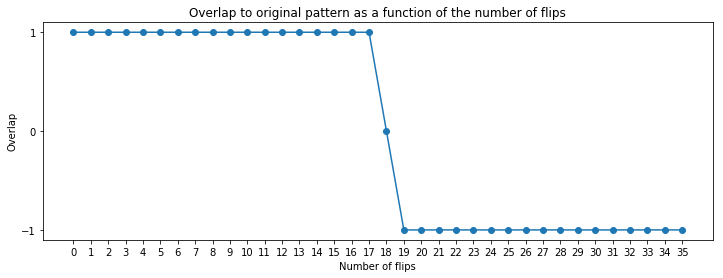

In [4]:
#Plot how different amount of bits flipped affect the state
states = plot_with_flip(5)
states = plot_with_flip(17)
states = plot_with_flip(18)
states = plot_with_flip(19)
plot_with_overlap()

What happens at nr_flipped_pixels = 18, what if nr_flipped_pixels > 18 ?

#### your answer 
* nr_flipped_pixels = 18

What we see is that since there is no correlation between the initial state and stored pattern the network fails to converge to a fixed point. Therefore the pattern is no longer able to be retrieved, which is illustrated by the overlap between the checkerboard and the final sequence being equal to 0

* nr_flipped_pixels > 18

Since the overlap is negative the deterministic update rule causes the state of each pixel to move towards the opposite of the stored pattern. As the default plotting tools don't do a good job of showing this (being only a set of blue squares for some reason), we plot the effect of negative overlap below.

Original pattern


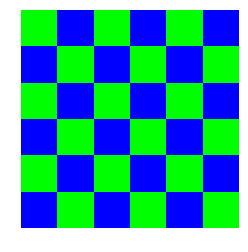

Noisy pattern with negative overlap


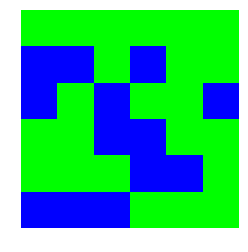

Final state of the pattern (Inverse of original)


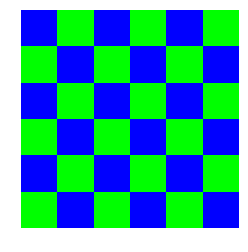

In [5]:
print("Original pattern")
plot_tools.plot_pattern(checkerboard)

print("Noisy pattern with negative overlap")
plot_tools.plot_pattern(states[0])

print("Final state of the pattern (Inverse of original)")
plot_tools.plot_pattern(states[5])

### 8.3.2. Question: the weights matrix
#### [1 + 3 + 2 points]

The patterns a Hopfield network learns are not stored explicitly. Instead, the network learns by adjusting the weights to the pattern set it is presented during learning. Let’s visualize this.

1. Create a new 6x6 network. Do not yet store any pattern.
2. What is the size of the network matrix?
3. Visualize the weight matrix using the function [`plot_tools.plot_nework_weights()`](https://neuronaldynamics-exercises.readthedocs.io/en/latest/modules/neurodynex.hopfield_network.html#neurodynex.hopfield_network.plot_tools.plot_nework_weights). It takes the network as a parameter.
4. Create a checkerboard, store it in the network.
5. Plot the weights matrix. What weight values do occur?
6. Create a new 6x6 network
7. Create an L-shaped pattern (look at the pattern factory doc), store it in the network
8. Plot the weights matrix. What weight values do occur?
9. Create a new 6x6 network
10. Create a checkerboard and an L-shaped pattern. Store both patterns in the network
11. Plot the weights matrix. What weight values do occur? How does this matrix compare to the two previous matrices?

***Note:*** The mapping of the 2 dimensional patterns onto the one dimensional list of network neurons is internal to the implementation of the network. You cannot know which pixel (x,y) in the pattern corresponds to which network neuron i.

Min -0.0277690163656 Max 0.0277768223896 Mean -0.000257478774602
Min -0.0277777777778 Max 0.0277777777778 Mean -0.000771604938272


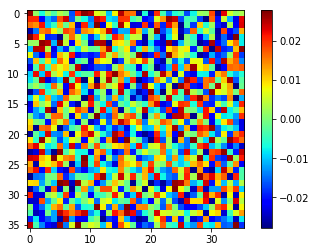

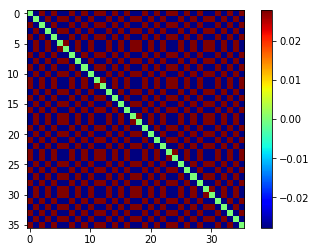

In [6]:
#1: Create a 6x6 network
pattern_size = 6
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
print("Min {} Max {} Mean {}".format(np.min(hopfield_net.weights), np.max(hopfield_net.weights), np.mean(hopfield_net.weights)))

#Save network for next question
h0 = hopfield_net

#2: The network is described by the 36x36 weight matrix

#3:
plot_tools.plot_nework_weights(hopfield_net)

#4:
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]
hopfield_net.store_patterns(pattern_list)

#5: Values from 0.0277777777778 to 0.0277777777778
plot_tools.plot_nework_weights(hopfield_net)
print("Min {} Max {} Mean {}".format(np.min(hopfield_net.weights), np.max(hopfield_net.weights), np.mean(hopfield_net.weights)))

#Save network for next question
h1 = hopfield_net


Min -0.0277777777778 Max 0.0277777777778 Mean 0.00342935528121
Min -0.0555555555556 Max 0.0555555555556 Mean 0.00265775034294


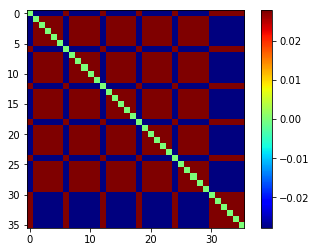

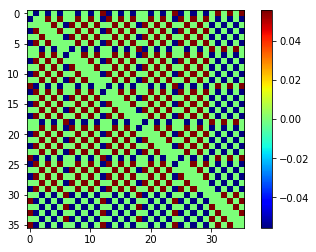

In [7]:
#6: Create a 6x6 network
pattern_size = 6
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)

#7:
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
L_pattern = factory.create_L_pattern()
pattern_list = [L_pattern]
hopfield_net.store_patterns(pattern_list)

#Save network for next question
h2 = hopfield_net

#8: Values from 0.0277777777778 to 0.0277777777778
plot_tools.plot_nework_weights(hopfield_net)
print("Min {} Max {} Mean {}".format(np.min(hopfield_net.weights), np.max(hopfield_net.weights), np.mean(hopfield_net.weights)))

#9:
pattern_size = 6
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)

#10
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
L_pattern  = factory.create_L_pattern()
checkerboard = factory.create_checkerboard()
pattern_list = [L_pattern , checkerboard]
hopfield_net.store_patterns(pattern_list)

#Save network for next question
h3 = hopfield_net

#11
plot_tools.plot_nework_weights(hopfield_net)
print("Min {} Max {} Mean {}".format(np.min(hopfield_net.weights), np.max(hopfield_net.weights), np.mean(hopfield_net.weights)))

How does this matrix compare to the two previous matrices?

#### your answer
The third matrix is obtained by summing up the values from the two previous matrices. The mean weight has become closer to 0 as evidenced by the greater amount of green as an effect of positive and negative weights cancelling each other out. The magnitude of the positive and negative weights seen in the third matrix have become more greater where the weights from the two patterns enhanced one another.

### 8.3.3. Question: Weights Distribution
#### *** Note:*** this exercise is NOT a bonus and it is graded
#### [2 points]

It’s interesting to look at the weights distribution in the three previous cases. You can easily plot a histogram by adding the following two lines to your script. It assumes you have stored your network in the variable ‘hopfield_net’. Explain the observed distribution (max 3 lines).

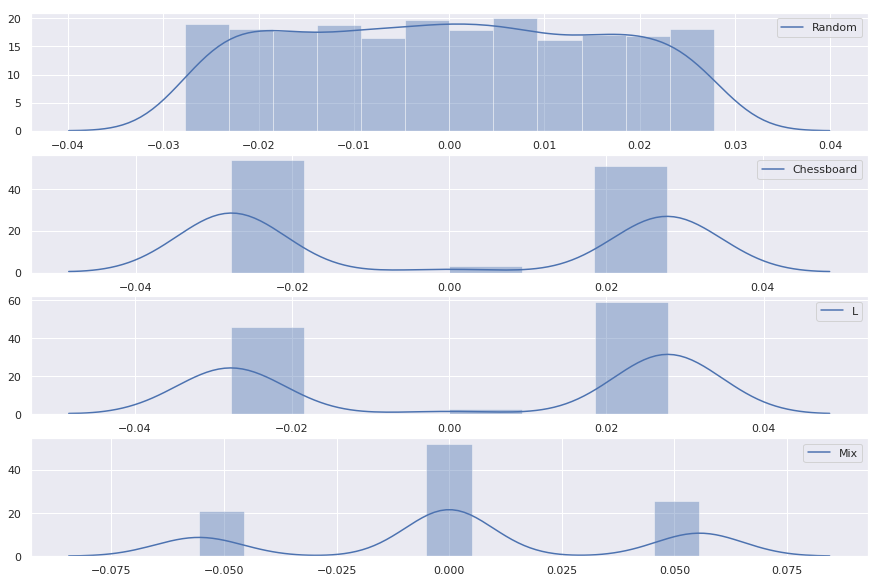

In [8]:
import seaborn as sns
sns.set()

fig, axs = plt.subplots(4, figsize=(15,10))
sns.distplot(h0.weights.flatten(), ax = axs[0], kde_kws={"label": "Random"}, axlabel = 'b')
sns.distplot(h1.weights.flatten(), ax = axs[1], kde_kws={"label": "Chessboard"})
sns.distplot(h2.weights.flatten(), ax = axs[2], kde_kws={"label": "L"})
sns.distplot(h3.weights.flatten(), ax = axs[3], kde_kws={"label": "Mix"})
plt.show()


#### your answer
The weight distribution of the checkboard pattern is very even, owing to the symmetric nature of the pattern. The weight distribution of the L-pattern has slightly more positive values given that it has an uneven distribution of pixels resulting in more positive weights (more elements connecting to the same pixel sign). The weight distribution of the third matrix is a combination of the two previous weight matrices and contains a majority of "neutral/zero" weights and fewer "stronger" negative and positive weights.

## 8.4. Exercise: Capacity of an N=100 Hopfield-network

Larger networks can store more patterns. There is a theoretical limit: the capacity of the Hopfield network. Read chapter [“17.2.4 Memory capacity”](http://neuronaldynamics.epfl.ch/online/Ch17.S2.html) to learn how memory retrieval, pattern completion and the network capacity are related.

### 8.4.1. Question:
#### [2 points]

A Hopfield network implements so called associative or content-adressable memory. Explain what this means. (max 4 lines)

#### your answer

Associative memory follows the principle that items are retrieved in memory in association with other conceptually related items. Furthermore,  memories (stored patterns) can be retrieved from incomplete or noisy input.The relationship between the items are characterized by the neuronal connections and the strengthing of these connections allow for the formation of memory. In the context of the Hopfield network, the network starts at an initial state and will evolve towards a pattern that is most closely correlated to that initial state.


### 8.4.2. Question:
#### [1 points]

Using the value $C_{store}$
 given in the book, how many patterns can you store in a N=10x10 network? Use this number K in the next question:

#### your answer 

The maximum number of patterns stored by a network can be determined using the following equation: C_store = M/N = K/N. Therefore with a theoretical limit of Cstore set to 0.138 such as to prevent an avalanche of changes upon further iterations, a maximum number of patterns stored is 13.8 ~ 13 patterns with 100 neurons.

In [9]:
N = 10 * 10
C = 0.138
K = int(np.floor(C*N))
K

13

### 8.4.3. Question:
#### [3+2 points]

Create an N=10x10 network and store a checkerboard pattern together with (K-1) random patterns. Then initialize the network with the unchanged checkerboard pattern. Let the network evolve for five iterations.

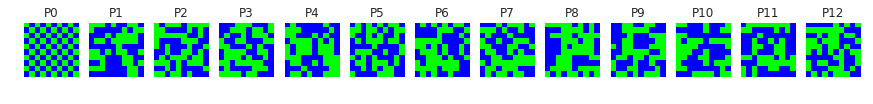

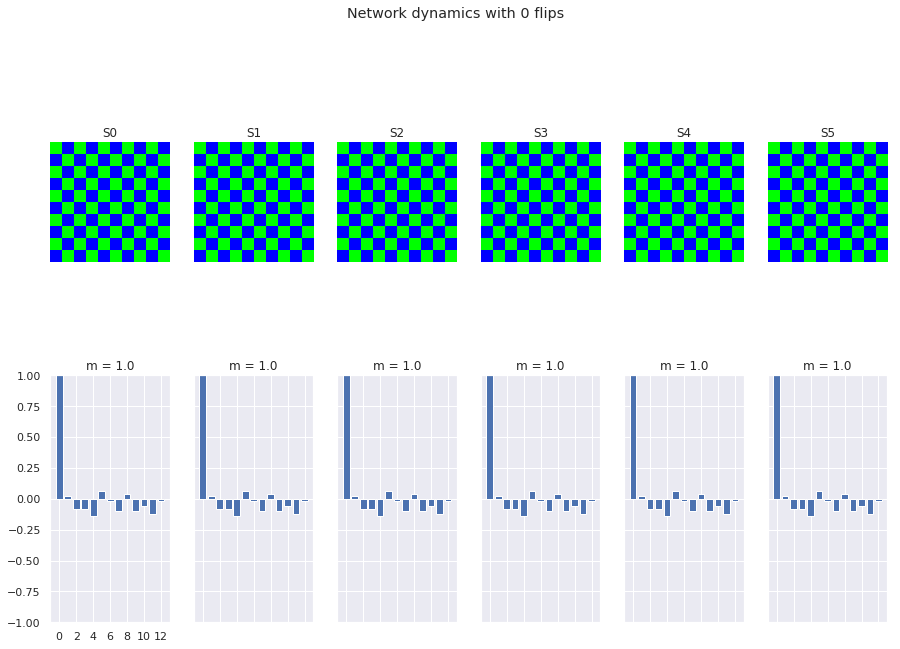

In [10]:
rcParams['figure.figsize'] = 15,10

pattern_size = 10

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)

# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)

# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=(K-1), on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)

hopfield_net.store_patterns(pattern_list)

#Start from the checkboard pattern
hopfield_net.set_state_from_pattern(pattern_list[0])
plot_with_flip(0)
plt.show()

Rerun your script a few times. What do you observe?

#### your answer
That the network never moves away from the initial state (checkerboard pattern). We haven't added enough memories (stored patterns) to destabilize the network, given that we start from a fixed point and we will remain at that fixed point.

## 8.5. Exercise: Non-random patterns

In the previous exercises we used random patterns. Now we us a list of structured patterns: the letters A to Z. Each letter is represented in a 10 by 10 grid.

### 8.5.1. Question:

Run the following code. Read the inline comments and look up the doc of functions you do not know.

the alphabet is stored in an object of type: <type 'dict'>
letters are patterns of size: (10, 10). Create a network of corresponding size


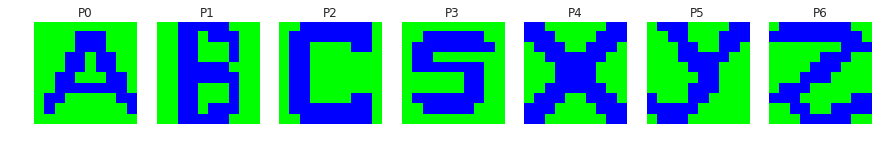

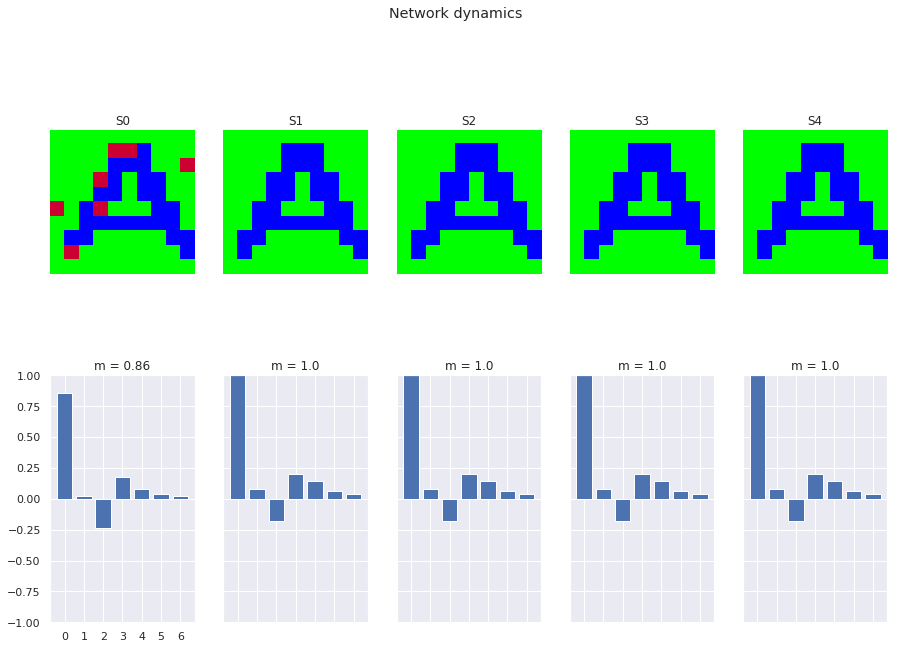

In [11]:
# the letters we want to store in the hopfield network
letter_list = ['A', 'B', 'C', 'S', 'X', 'Y', 'Z']

# set a seed to reproduce the same noise in the next run
np.random.seed(26)

abc_dictionary =pattern_tools.load_alphabet()
print("the alphabet is stored in an object of type: {}".format(type(abc_dictionary)))

# access the first element and get it's size (they are all of same size)
pattern_shape = abc_dictionary['A'].shape
print("letters are patterns of size: {}. Create a network of corresponding size".format(pattern_shape))

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_shape[0]*pattern_shape[1])

# create a list using Pythons List Comprehension syntax:
pattern_list = [abc_dictionary[key] for key in letter_list ]
plot_tools.plot_pattern_list(pattern_list)

# store the patterns
hopfield_net.store_patterns(pattern_list)

# # create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.get_noisy_copy(abc_dictionary['A'], noise_level=0.2)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=4)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = pattern_tools.reshape_patterns(states, pattern_list[0].shape)

# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(
    states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

### 8.5.2. Question:
#### [2 + 3 points]

Add the letter ‘R’ to the letter list and store it in the network.

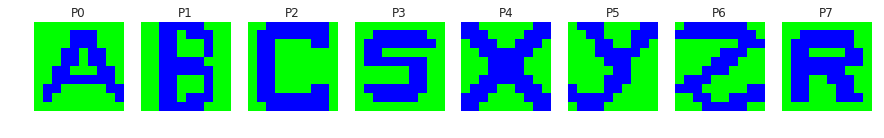

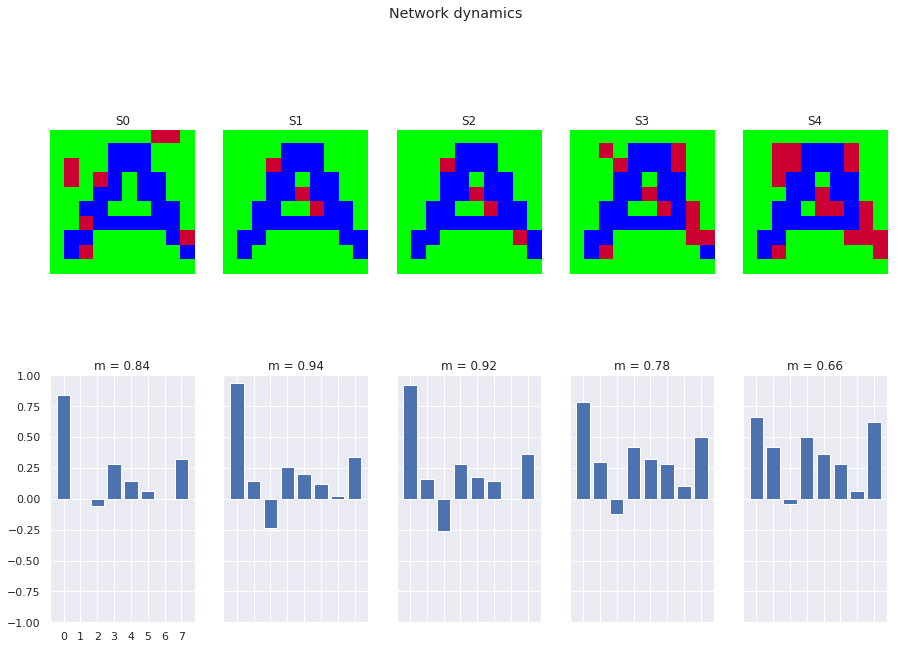

In [12]:
# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_shape[0]*pattern_shape[1])

#Append R
letter_list = ['A', 'B', 'C', 'S', 'X', 'Y', 'Z', 'R']
pattern_list = [abc_dictionary[key] for key in letter_list ]

#Check that it's in the list
plot_tools.plot_pattern_list(pattern_list)

# store the patterns
hopfield_net.store_patterns(pattern_list)

noisy_init_state = pattern_tools.get_noisy_copy(abc_dictionary['A'], noise_level=0.2)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=4)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = pattern_tools.reshape_patterns(states, pattern_list[0].shape)

# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(
    states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")

Is the pattern ‘A’ still a fixed point? Does the overlap between the network state and the reference pattern ‘A’ always decrease? (max 3 lines)

#### your answer
The pattern 'A' no longer appears to be a fixed point given that the overlap no longer stabilizes at a value close to or equal to 1 after a certain number of iterarions. Initially the overlap does increase, but then the overlap always appears to decrease. 

### 8.5.3. Question:
#### [3 + 3 points]

Make a guess of how many letters the network can store. Then create a (small) set of letters. Check if all letters of your list are fixed points under the network dynamics. 

In [13]:
def test_retrieval_of_letter(letter_list, letter):
    """
        Convenience function for checking if a letter can be retrieved from a network
        Initialized with a noisy version of 'letter'
        Returns 1 if the final state of the network perfectly matches the letter, 0 otherwise
    """
    
    hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_shape[0]*pattern_shape[1])

    # create a list using Pythons List Comprehension syntax:
    pattern_list = [abc_dictionary[key] for key in letter_list ]
    
    # store the patterns
    hopfield_net.store_patterns(pattern_list)

    # create a noisy version of a pattern and use that to initialize the network
    noisy_init_state = pattern_tools.get_noisy_copy(abc_dictionary[letter], noise_level=0.2)
    hopfield_net.set_state_from_pattern(noisy_init_state)
    
    states = hopfield_net.run_with_monitoring(nr_steps=5)
    
    #Reshape the state of the network into patterns
    states_as_patterns = pattern_tools.reshape_patterns(states, pattern_list[0].shape)
    
    
    #Compare the final pattern with the one we wanted to see if we could store
    original_pattern = abc_dictionary[letter]
    final_pattern = states_as_patterns[4]
    
    return int(np.array_equal(original_pattern, final_pattern))

In [14]:
def test_retrieval_in_list(letter_list):
    """
    Tries to retrieve each letter in list, returns fraction of successful retrievals
    """
    retrievals = 0
    for letter in letter_list:
        result = test_retrieval_of_letter(letter_list, letter)
        retrievals += result
    return retrievals/len(letter_list)

In [15]:
def sub_lists(list1): 
    """
    Generates all possible sublists of a list
    """
    # store all the sublists  
    sublist = [[]] 
    for i in range(len(list1) + 1):  
        for j in range(i + 1, len(list1) + 1):       
            # slice the subarray  
            sub = list1[i:j] 
            sublist.append(sub) 
              
    return sublist 

In [16]:
#Select 15 letters to try
letter_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H','I','J','L','M', 'N','O','P']

#Generate all possible subsets of the list
super_lists = sub_lists(letter_list)

final_result = []

#For each possible cardinality
for cardinality in range(1, len(letter_list) +1):
    
    #Get all subsets with the respective cardinality
    sub_result = 0
    divisors = 0
    for sub_list in super_lists:
        if len(sub_list) == cardinality:
            
            #Get fraction of successfull retrievals in this list
            result = test_retrieval_in_list(sub_list)
            sub_result += result
            divisors +=1
            
    #Calculate the average recall of patterns on lists of current cardinality
    average = sub_result/divisors
    final_result.append(average)


Text(0.5,1,u'Average pattern retrieval across different amounts of stored patterns')

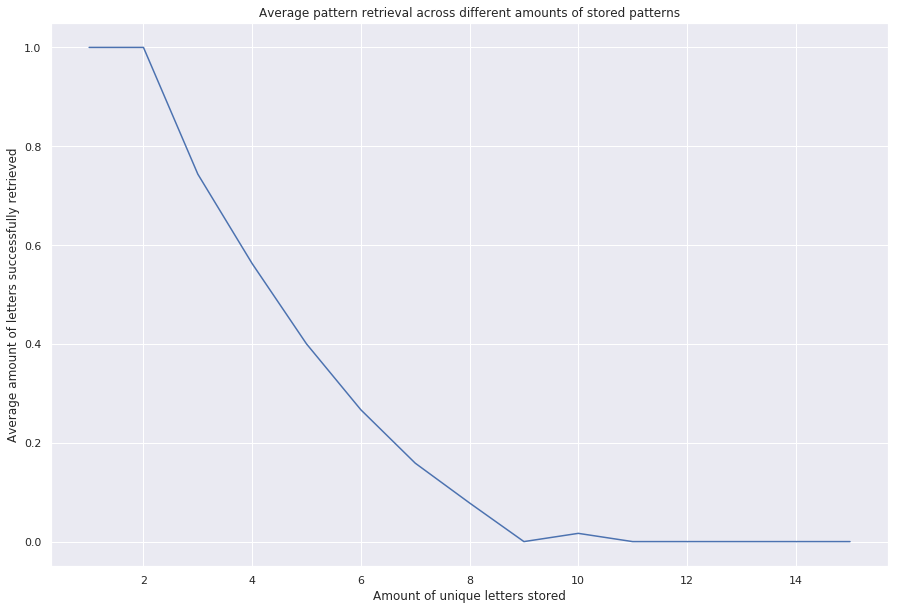

In [17]:
fig, ax = plt.subplots(figsize =( 15,10))
sns.lineplot(x = np.arange(1,len(letter_list) + 1), y = final_result, ax = ax)
ax.set_ylabel('Average amount of letters successfully retrieved')
ax.set_xlabel('Amount of unique letters stored')
ax.set_title('Average pattern retrieval across different amounts of stored patterns')

Explain the discrepancy between the network capacity C (computed above) and your observation. (max 4 lines)

#### your answer
Based on the above graph perfect recall (regardless of letters tested) is only possible up to two items. After that the percentage of successfull pattern retrievals seems to decline in an approximately linear fashion with respect to amount of items stored, hitting 0 when we store > 10 patterns.

The key to this discrepancy between the C we calculated (13 patterns) and what we observed is that the theoretical C was based on the assumption of *random* patterns generated by independent random numbers with zero mean. Letters do not fall into this definition of random patterns and as such they are so correlated (high inter-pattern overlap) that the convergence to a single pattern is less likely. 

It is important to note that the actual values we see in the graph above would depend on choice of letters since their overlap would be different, testing for the whole alphabet would be too time-consuming however. 

## 8.6 Low activity attractor network

Hopfield networks are a useful abstraction in order to understand how associative memory works. 
However they are quite far from biological plausibility. One step towards a more bioplausible attractor network is to consider sparse patterns. In the traditional Hopfield network you have analysed so far, each pattern counts 50% of active units, now we consider patterns that only have a small fraction `f` of active units. 

A simple low activity attractor network is described in this [paper](https://www.mitpressjournals.org/doi/full/10.1162/NECO_a_00499) ("Scaling Laws of Associative Memory Retrieval" by Sandro Romani, Itai Pinkoviezky, Alon Rubin and Misha Tsodyks). 
The goal of this exercise is to understand the network model proposed in the first part of the paper and reproduce Fig.1.

Start by reading the introduction, ***section 2.1*** and ***A.1*** of the paper (that's all you'll need for the exercise).

***Note:*** In what follows we stick to the same notation of the paper. If you are confused about the meaning of a variable, you know were to find it!

### 8.6.1 Patterns and weight matrix
#### [1 + 2 + 2  points]

Start by implementing L sparse patterns. You can store them into a $L\times N$ matrix called `items`. In what follows, use the indications given in the comments.

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
## Initialize the parameters like in the paper ## 
N = 3000
L = 16
f = 0.1
T = 0.015
Dth = 1.9*T
Tth = 45
TJ0 = 25
min_J0 = 0.7
max_J0 = 1.2
timesteps = 1000  ## for this one, check out Fig.1
mean = 1/2 * (max_J0 + min_J0)
np.random.seed(26) ## KEEP THE SEED FIXED FOR CORRECTION ##

Synaptic weight matrix


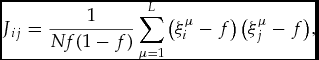

In [20]:
from IPython.display import Image
print("Synaptic weight matrix")
display(Image("assets/weights.jpg"))

In [21]:
## Initialize patterns and weights (!!! for loops = -1 point !!!)

items = np.random.binomial(1,f,(L, N)) ## find the right probability distibution within the numpy.random library
## Check that items has the right shape
print "Shape of items",  np.shape(items)

J = 1/(N*f*(1-f))*np.dot(np.transpose(items-f),items-f)#??? ## implement the definition of the weight matrix, find the right numpy function for matrix multiplication
## Check that J has the right shape
print "Shape of items",  np.shape(J)

Shape of items (16, 3000)
Shape of items (3000, 3000)


Explain why we need to subtract `f` in the weight formula. (max 5 lines)
#### [4 points]

#### your answer
According to Amit et al. (1987), the introduction of the f parameter is necessary in order to store biased patterns. The total activity for a network follows the equation below, therefore f also represents the mean activity. The authors explain how the noise generated by other patterns in the retrieval of each pattern is not equal to zero, thus stored patterns at low storage levels become unstable. Therefore, to counteract this effect, subtracting the mean activity from each neuron results in shifting the mean of the noise back to zero.
\begin{equation}
    \sum_{\mu}{\zeta}_{i}^\mu = Nf
\end{equation}

Reference: Amit, Daniel J., Hanoch Gutfreund, and Haim Sompolinsky. "Information storage in neural networks with low levels of activity." Physical Review A 35.5 (1987): 2293.

Now initialize the threshold.
#### [2  points]

In [22]:
## Initilize the thtrshold
thresh = np.random.uniform(-T,T,(N)) ## find the right probability distibution within the numpy.random library
thresh_0 = np.copy(thresh)
thresh

array([-0.00263172,  0.00929375,  0.00587204, ..., -0.01499203,
        0.00687074, -0.01115807])

### 8.6.2 Dynamical evolution
Now implement a function that let the state of the system evolve (for Fig.1A) and a second one which computes the overlaps between items (for Fig.1B) (use again the right numpy function for matrix multiplication and check out a numpy function for $\Theta$).

***Note:*** Don't confuse the overlap between the current state and the stored patterns and the overlap between patterns.
#### [4 + 1 points]

Neuron update rule


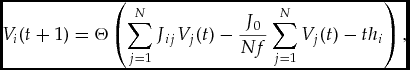

Threshold update rule


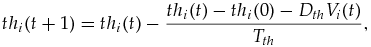

Network state (similarity between state and a pattern)


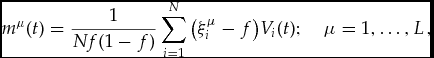

In [23]:
print("Neuron update rule")
display(Image("assets/next_state.jpg"))
"Vtranspose * J - J0/Nf"
print("Threshold update rule")
display(Image("assets/thresh.jpg"))
print("Network state (similarity between state and a pattern)")
display(Image("assets/overlap.jpg"))

In [24]:
def evolve(V_,thresh_,J0_):
    overlap_ = 1/(N*f*(1-f))*np.dot(items-f,V_)## write the overlap formula at time t 

    V_old = np.copy(V_)
    V_ = np.heaviside(np.dot(J,V_old) - (J0_/(N*f))*np.sum(V_old) - thresh_,0)       ## write the update formula for time t+1
    
    thresh_ = thresh_ -(thresh_-thresh_0-Dth*V_old)/Tth ## update the threshold for time t+1
    
    return V_,thresh_, overlap_

def overlap_mat(a,b):
    return np.dot(a,np.transpose(b))    ## if a and b are two patterns, what's the overlap between them?

Run the dynamics and plot $J_0(t)$.
#### [4 + 1  points]

In [25]:
## Here we prepare a dictionary in which to store the state, J0, threshold and overlap for each time step ## 
dic_evolution = {}
dic_evolution['J0'] = []
dic_evolution['V'] = []
dic_evolution['thresh'] = []
dic_evolution['overl'] = []

## Set the initial state of the matrix equal to the first pattern
dic_evolution['V'].append(items[0])
dic_evolution['thresh'].append(thresh_0)

## Now we are ready to run the dynamics 
for i in range(timesteps):
    #print(np.shape(dic_evolution['V']))
    J0 = (max_J0 - mean)*np.sin((i)*2*np.pi/25)+mean ## use numpy.sin() to have the correct osclillatory behavior. Don't forget to scale it correctly
    
    #Retrieve the current state of the neurons
    current_V = dic_evolution['V'][i]
    
    #Retrieve current state of thresholds
    current_th = dic_evolution['thresh'][i]
    
    V_,thresh_, overlap_ = evolve(current_V ,current_th,J0)
    
    dic_evolution['J0'].append(J0) 
    dic_evolution['V'].append(V_)
    dic_evolution['thresh'].append(thresh_)
    dic_evolution['overl'].append(overlap_)

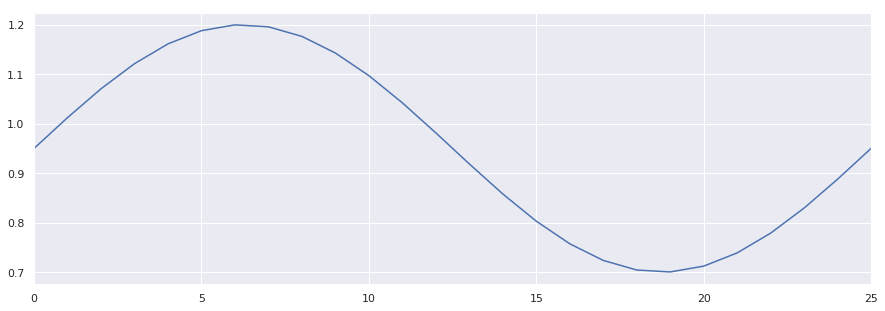

In [26]:
## check that you have the right evolution of J0
fix, ax = plt.subplots(figsize = (15, 5))
plt.plot( dic_evolution['J0'])
plt.xlim([0,TJ0])  ## plot for one period

plt.show()

### 8.6.3 Plot the figures
#### [2 + 4 points]

(1000, 16)


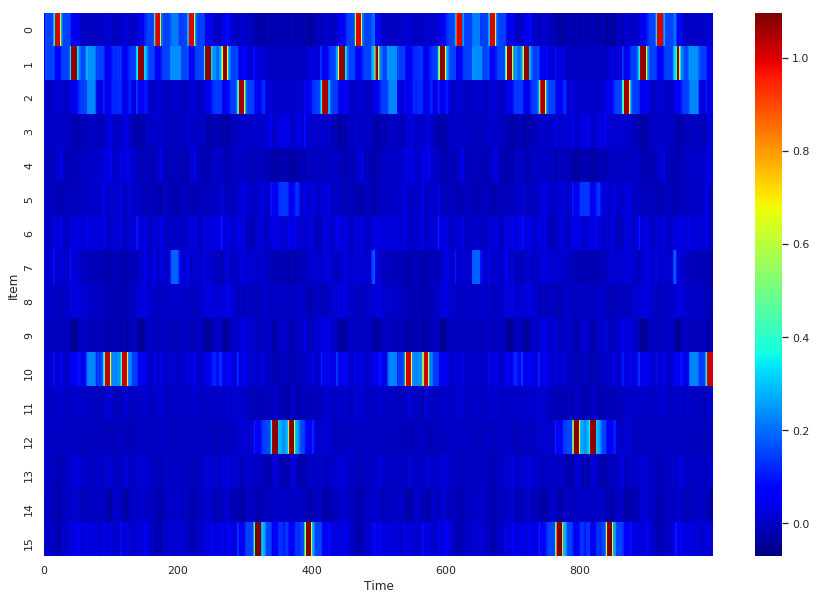

In [27]:
## Plot Fig. 1A 
print(np.shape(dic_evolution['overl']))
plt.figure( figsize = [15, 10] ) ## check out the inputs, how do you fix the figure size?
sns.heatmap( np.transpose(dic_evolution['overl']), cmap="jet", xticklabels=200)
plt.xlabel('Time')
plt.ylabel('Item')
## add a colorbar here
plt.show()

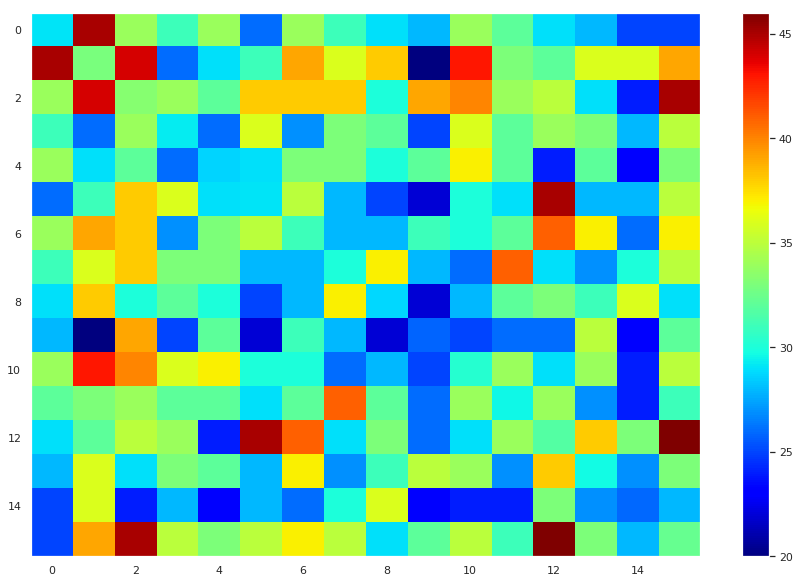

In [28]:
## Plot Fig. 1B
## first you need to create a matrix filled with the overlaps between patterns.
overlap_matrix = np.zeros((L,L))  ## declare a matrix of 0s with the right shape. One more time, numpy is going to be useful.
for i in range( L ):
    for j in range(i, L ):
        if i != j:
            overlap_matrix[i,j] = overlap_matrix[j,i] = overlap_mat(items[i,:],items[j,:])#??? ## insert the right expression for the element of overlap_matrix

#Make the diagonal the average of the whole matrix
overlap_matrix += np.diagflat(np.average(overlap_matrix,axis=1)) 

fig, ax = plt.subplots(figsize = (15,10))
plt.imshow( overlap_matrix, interpolation = 'None', aspect = 'auto', cmap = 'jet') ## Insert the right dictionary 
plt.xticks(rotation='horizontal')
plt.yticks(rotation='horizontal')
## add a colorbar here
plt.colorbar()
ax.grid(False)
plt.show()


Comment your first figure: do you notice any recurrence in the item retrieval? How do they interpret it in the paper? 
Now explain the link between the first and the second figure. (max 12 lines)
#### [8 points]

#### your answer
In figure 1 we observe recurrency in the item retrieval of patterns 0, 1, 2, 10, 12 and 15. Regardless of which pattern we initialize the nework with these (6) patterns eventually end up getting retrieved in a set order in a stable loop. Experimentally testing different item matrices we see that the amount of patterns retrieved may differ, but the cyclic behavior of pattern retrieval is constant.

In the paper they conclude that the dynamics of this type of network enter a stable loop after several iterations, retrieving the same subset of patterns. They also note that the fact that only a subset is retrieved is not due to the effect of limited capacity of the network as all items can be retrieved when cued individually.

The link between the two images is that _"network transitions typically occur between attractors with the largest intersection"_ as stated in the paper. The patterns that share a high number of active neurons as seen in figure 2 are the patterns retrieved in transition one after the other as seen in figure 1.

This makes sense as similar patterns require fewer modifications to be transformed into one another. As the network evolves it is more likely to "fall" into a similar pattern than a dissimilar one. Since the neuronal adaption implemented this model prevents the network from immediately falling back to the previous pattern, the cyclic retrieveal between patterns above occurs, and the amount of patterns (and which) retrieved depend on the similarity between the patterns in question.
